In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Определение возраста покупателей

**Заказчик** — сетевой супермаркет «Хлеб-Соль».

**Цель исследования**:
1. Построить систему, способную давать оценку приблизительному возрасту покупателя в прикассовой зоне по фотографии.

**Поставленные задачи**
1. Изучить предоставленные данные и подготовить их для обучения моделей.
2. Обучить нейронную сеть с минимальным показателем метрики (показатель не должен превышать MAE = 8).
3. Проверить качество выбранной модели на тестовой выборке.

**Дальнейшее использование**

Результаты исследования будут использоваться в дальнейшем при анализировании перечня товаров, интересных разным возрастным группам, а также позволят контролировать добросовестность кассиров при продаже алкоголя.

**Дополнительно предоставленная инфомарция**

- Имеется набор данных: фотографии людей с указанием возраста.

## Исследовательский анализ данных

Загрузим данные из датасета и посмотрим на них

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


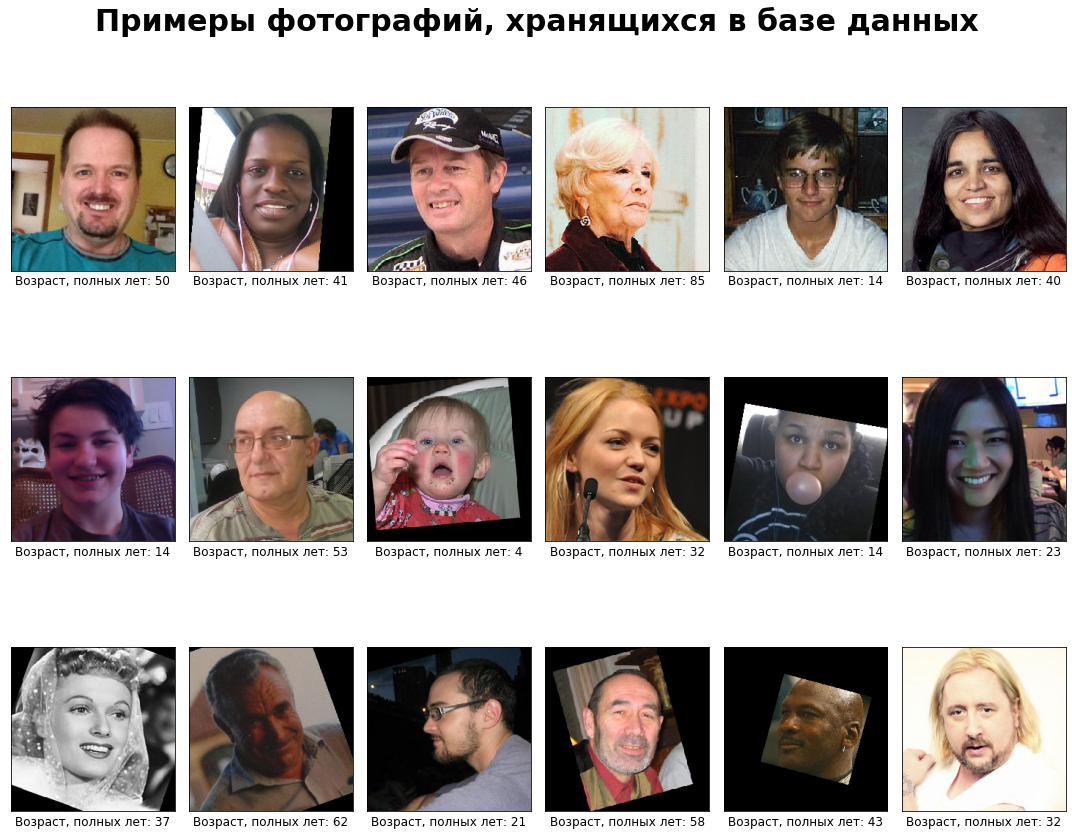

In [5]:
features, target = next(train_gen_flow)

# выведем 18 хранящихся внутри нашего датасета фотографий

fig = plt.figure(figsize=(15,15))
fig.suptitle('Примеры фотографий, хранящихся в базе данных', y = 0.9,
             fontsize = 30, fontweight='bold')
    
for i in range(18):
    fig.add_subplot(3, 6, i+1)
    plt.imshow(features[i])
    #plt.title(f'Возраст, полных лет: {list(target)[i]}')
    
    plt.xlabel(f'Возраст, полных лет: {list(target)[i]}', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Затем построим гистограмму распределения возрастов в нашем датасете

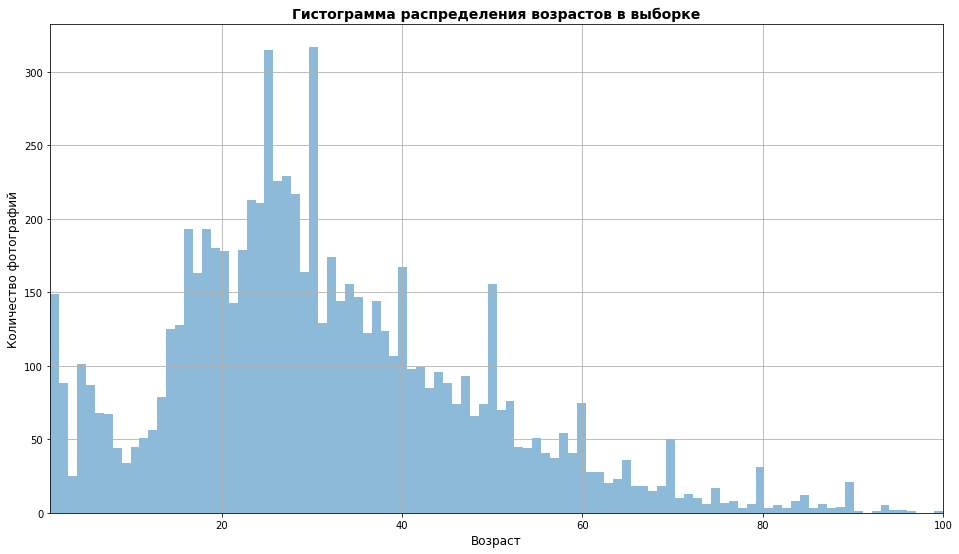

In [6]:
plt.figure(figsize=[16,9])

plt.hist(labels['real_age'], 
         bins=100, 
         alpha=.5)

plt.xlim([1, 100])

plt.xlabel('Возраст', fontsize = 12)
plt.ylabel('Количество фотографий', fontsize = 12)
plt.grid(True)

plt.title('Гистограмма распределения возрастов в выборке', fontsize = 14, fontweight='bold')
plt.show()

Видны скачки на определенных возрастах: 1, 25, 30, 40, 50, 60, 70, 80, 90. Возможно это связано с усреднением возраста людей на фотографиях, по которым нет точных данных. Выбросы могут быть также связаны с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он его попросту округлял до "юбилейных" лет. Поэтому, некоторые "круглые" года в датасете некорректные.

### Выводы
Наш датасет состоит из фотографий с указанием возраста людей, изображенных на них. В ходе первичного осмотра данных выяснили:
- имеется 7591 объектов с разбросом возрастов от 1 года до 100 лет;
- размер фотографий предустановлен при загрузке 224x224 пикселей;
- фотографии представлены разного качества: 
    * на некоторых присутствует чрезмерное размытие;
    * есть сильно сжатые фотографии;
    * низкого качества либо изначально маленькое, сильно пиксельное;
    * старые фото представлены в ЧБ формате в связи с доступными на тот момент технологиями;
    * есть повернутые фотографии, однако, изменение ориентации скорее искусственное, выполненное машиной с целью восстановить горизонт и правильно расположить лицо относительно вертикали - это видимо способствует лучшему распознаванию черт лица (однако встречаются и неверно перевернутые);
    * преобладают фотографии в анфас, что позволит лучше считывать лицо человека, но также - в профиль, скорее для выявления второстепенных признаков возраста.
- преобладают данные о людях среднего возраста от 18 до 38 лет и младенце;
- мало объектов старше 60 лет, что может негативно сказаться на обучении модели из-за недостатка примеров;

## Обучение модели

Код для выполнения обучения модели представлен ниже

```

def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                        rescale=1./255, 
                                        horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=180, activation='relu'))
    model.add(Dense(units=120, activation='relu'))    
    model.add(Dense(units=60, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

Получившиеся выходные данные с результатами по эпохам:

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 107s - loss: 240.2017 - mae: 11.1581 - val_loss: 568.8712 - val_mae: 18.8009

Epoch 2/5
178/178 - 69s - loss: 71.2890 - mae: 6.3727 - val_loss: 595.1909 - val_mae: 19.3699

Epoch 3/5
178/178 - 48s - loss: 43.4734 - mae: 5.0038 - val_loss: 273.2992 - val_mae: 12.2159

Epoch 4/5
178/178 - 52s - loss: 33.3334 - mae: 4.3477 - val_loss: 111.8118 - val_mae: 7.9403

Epoch 5/5
178/178 - 53s - loss: 24.5231 - mae: 3.7385 - val_loss: 79.0134 - val_mae: 6.7536

```

## Анализ обученной модели

В ходе обучения модели получили значение **MAE равное 6.754**, что является отличным результатом. Для обучения нам понадобилось 5 эпох со скоростью обучения 0.0001 с помощью алгоритма Adam.

Описание параметров полученной модели:

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 180)               368820    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               21720     
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 61        
=================================================================
Total params: 23,985,573
Trainable params: 23,932,453
Non-trainable params: 53,120

```

Полученная модель в достаточной степени позволяет решить поставленную задачу, а именно распознавать приблизительный возраст людей для дальнейшего анализа и контроля. К существующей базе можно добавить еще фотографий людей после 60 и до 16 лет, что позволит в дальнейшем получить более достоверные предсказания. Также можно поиграться с поворотами фотографий, так как в исходной выборке присутствуют неверно преобразованные (повернутые) фотографии относительно вертикали. 

Сделаны следующие наблюдения относительно исходных данных:
- размер фотографий предустановлен при загрузке 224x224 пикселей, однако видно, что изначально присутствовали объекты низкого разрешения (которые пикселят), низкого качества (сильно размытые, обрезанные или вытянутые), что говорит о разном первоначальном размере;
- среди изображений присутствуют ЧБ-лые в связи с доступными на тот момент технологиями;
- есть повернутые фотографии, однако, изменение ориентации скорее искусственное, выполненное машиной с целью восстановить горизонт и правильно расположить лицо относительно вертикали - это видимо способствует лучшему распознаванию черт лица (однако встречаются и неверно перевернутые);
- преобладают фотографии в анфас, что позволит лучше считывать лицо человека, но также - в профиль, скорее для выявления второстепенных признаков возраста.
- преобладают данные о людях среднего возраста от 18 до 38 лет и младенце;
- мало объектов старше 60 лет и до 16 лет, что может негативно сказаться на обучении модели из-за недостатка примеров.